In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
data_df=pd.read_csv("AmesHousing.tsv",delimiter='\t')
print(data_df.head(2))
print(data_df.shape)

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   

  Alley Lot Shape Land Contour    ...     Pool Area Pool QC  Fence  \
0   NaN       IR1          Lvl    ...             0     NaN    NaN   
1   NaN       Reg          Lvl    ...             0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0          NaN        0       5    2010       WD           Normal     215000  
1          NaN        0       6    2010       WD           Normal     105000  

[2 rows x 82 columns]
(2930, 82)


In [7]:
def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train=df[:1460]
    test=df[1460:]
    numeric_train=train.select_dtypes(include=['integer','float'])
    numeric_test=test.select_dtypes(include=['integer','float'])
    features=numeric_train.columns.tolist()
    features.remove('SalePrice')
    target='SalePrice'
    model=linear_model.LinearRegression()
    model.fit(numeric_train[features],numeric_train[target])
    predicted_values=model.predict(numeric_test[features])
    mse=mean_squared_error(numeric_test[target],predicted_values)
    rmse=np.sqrt(mse)
    return rmse
transform_df = transform_features(data_df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.251612639091

# Findings:-

As it can be seen from the value that the linear regression model that was constructed off of all the numeric column in the table gave a bad model due to the high rmse value therefore further improvement of the model is required.

In [12]:
serie=data_df.isnull().sum()[data_df.isnull().sum()>0]
missing_data=data_df[serie.index]
missing_data.isnull().sum()

Lot Frontage       490
Alley             2732
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

In [14]:
num_missing = data_df.isnull().sum()
drop_missing_cols = num_missing[(num_missing > len(data_df)/20)].sort_values()
df = data_df.drop(drop_missing_cols.index, axis=1)
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
df = df.drop(drop_missing_cols_2.index, axis=1)

In [17]:
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
print(fixable_numeric_cols)
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64


{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [19]:
df = df.fillna(replacement_values_dict)
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [20]:
years_sold = df['Yr Sold'] - df['Year Built']
print(years_sold[years_sold < 0])
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
print(years_since_remod[years_since_remod < 0])

2180   -1
dtype: int64
1702   -1
2180   -2
2181   -1
dtype: int64


In [21]:
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod
df = df.drop([1702, 2180, 2181], axis=0)
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
df = df.drop(["PID", "Order"], axis=1)
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

In [22]:
len(df.columns)

58

In [26]:
def transform_features(df):
    missing_data=df.isnull().sum()
    miss_cols=missing_data[missing_data>len(df)/20]
    df=df.drop(miss_cols.index,axis=1)
    txt_cols_missing=df.select_dtypes(include=['object']).isnull().sum()
    txt_cols=txt_cols_missing[txt_cols_missing>0]
    df=df.drop(txt_cols.index,axis=1)
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    dict_temp=replacement_values_dict
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    df = df.drop(["PID", "Order"], axis=1)
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413073

# Findings:-

On removing a few data leaks and the empty values the value of the rmse decreased by a few thousand, thus improving the model a bit but not that much.

In [30]:
dat=transform_df.select_dtypes(include=['int', 'float'])
selected_=dat.corr()['SalePrice'].abs().sort_values()
selected_

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

Index(['BsmtFin SF 1', 'Fireplaces', 'TotRms AbvGrd', 'Mas Vnr Area',
       'Years Since Remod', 'Full Bath', 'Years Before Sale', '1st Flr SF',
       'Garage Area', 'Total Bsmt SF', 'Garage Cars', 'Gr Liv Area',
       'Overall Qual', 'SalePrice'],
      dtype='object')


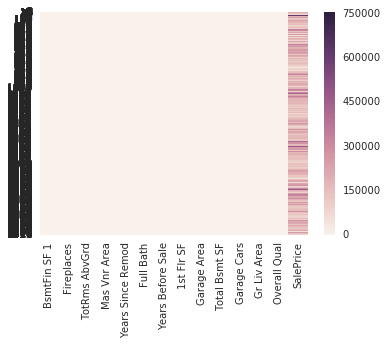

In [37]:
greater_selected_cols=selected_[selected_>0.4].index
print(greater_selected_cols)
import seaborn as sns
%matplotlib inline
sns.heatmap(transform_df[greater_selected_cols])

In [38]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

Central Air      2
Street           2
Land Contour     4
Lot Config       5
Bldg Type        5
Heating          6
Roof Style       6
Foundation       6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
MS SubClass     16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [39]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[27049.123180780138, 27508.06680660462, 26342.362358017221, 34943.425621000824]


28960.744491600701